# LSTM and GRU with cortical electrophys
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Run the first three cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-alpha0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell
%load_ext tensorboard.notebook

In [3]:
# Download and unzip data (3.4 GB)
datadir = Path.cwd() / 'data' / 'joeyo'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted')} cboulay/joeyo_nhp_reach_mea
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare Data

### Import

Y has finger position (3-D), cursor position (2-D; direct projection of finger position), and the target position. We need only the cursor position, so we select only those channels from Y.

In [130]:
from data.utils.fileio import load_joeyo_reaching
sess_names = ['indy_201' + _ for _ in ['60921_01', '60927_04', '60927_06', '60930_02', '60930_05', '61005_06',
                                       '61006_02', '60124_01', '60127_03']]
SESS_IDX = 0
BEHAV_CHANS = ['CursorX', 'CursorY']

sess_name = sess_names[SESS_IDX]
X, Y, X_ax_info, Y_ax_info = load_joeyo_reaching(datadir, sess_name, x_chunk='mu_spiketimes')

# Slice Y to only keep required behaviour data.
b_keep_y_chans = np.in1d(Y_ax_info['channel_names'] , BEHAV_CHANS)
Y = Y[b_keep_y_chans, :]
Y_ax_info['channel_names'] = [_ for _ in Y_ax_info['channel_names'] if _ in BEHAV_CHANS]

### Visualize Data

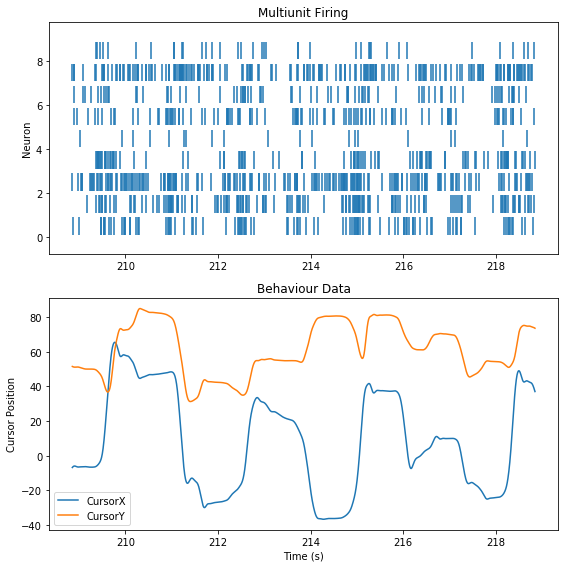

In [188]:
PLOT_T_RANGE = [30, 40]
X_SKIP_NEURONS = 10

plt_t_range = np.array(PLOT_T_RANGE, dtype=np.float64)
plt_t_range += Y_ax_info['timestamps'][0]

fig = plt.figure(figsize=(8, 8), facecolor='white')

plt.subplot(2, 1, 1)
# identify which samples in X fall within our time range
b_x = np.logical_and(X_ax_info['timestamps'] >= plt_t_range[0],
                     X_ax_info['timestamps'] < plt_t_range[1])
t_x = X_ax_info['timestamps'][b_x]  # vector of timestamps
X_subset = X[::X_SKIP_NEURONS, b_x]
# X is sparse. We use nonzero() to get its indices,
# then use the indices to index our timestamp vector to get spike times.
spk_t_list = [t_x[_.nonzero()[1]] for _ in X_subset]
plt.eventplot(spk_t_list, lineoffsets=0.5+np.arange(len(spk_t_list)), linelengths=0.8)
# plt.plot(t_vec[1000:2000], X[::10, b_x_ts].T)
plt.title('Multiunit Firing')
plt.ylabel('Neuron')

plt.subplot(2, 1, 2)
b_y = np.logical_and(Y_ax_info['timestamps'] >= plt_t_range[0],
                     Y_ax_info['timestamps'] < plt_t_range[1])
plt.plot(Y_ax_info['timestamps'][b_y], Y[0, b_y].T, label=Y_ax_info['channel_names'][0])
plt.plot(Y_ax_info['timestamps'][b_y], Y[1, b_y].T, label=Y_ax_info['channel_names'][1])
plt.title('Behaviour Data')
plt.xlabel('Time (s)')
plt.ylabel('Cursor Position')
plt.legend()

plt.tight_layout()
plt.show()

### Bin Spike Times
Almost everyone working with these type of data convert spike times to rates. We are no different.

First we count spikes in each bin.

In [190]:
X

<88x351707 sparse matrix of type '<class 'numpy.bool_'>'
	with 413050 stored elements in Compressed Sparse Row format>

In [ ]:
def bin_spikes(spike_times,dt,wdw_start,wdw_end):
    """
    Function that puts spikes into bins
    Parameters
    ----------
    spike_times: a CSR-format sparse matrix of shape (n_neurons, m_times)
    fs: the sampling rate of spike_times
    dt: bin duration (seconds)
    wdw_start: number (any format)
        the start time for putting spikes in bins
    wdw_end: number (any format)
        the end time for putting spikes in bins
    Returns
    -------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    """
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1 #Number of bins
    num_neurons=spike_times.shape[0] #Number of neurons
    neural_data=np.empty([num_bins,num_neurons]) #Initialize array for binned neural data
    #Count number of spikes in each bin for each neuron, and put in array
    for i in range(num_neurons):
        neural_data[:,i]=np.histogram(spike_times[i],edges)[0]
    return neural_data

### Prepare for TensorFlow

Both X and Y come in shape (channels, samples) as float64. They both need to be float32.

Neural data needs to be in shape (segments, taps, channels) where `taps` is the number of samples of neural data history used to predict each sample in Y.

Finally, we split into training and validation sets. This time we do not shuffle.

In [118]:
N_TAPS = 10
P_TRAIN = 0.8
BATCH_SIZE = 256

# We want to use N_TAPS worth of neural data to predict each step in Y.
# We thus cannot predict the first (N_TAPS - 1) Y values because we don't have the previous taps in X.
_Y = Y[:, (N_TAPS - 1):].T.astype(np.float32)

# We will use a brute-force way to make the _X output with shape (n_sequences, N_TAPS, n_neurons)
# where each entry in N_TAPS dimension is just a t+1 shifted version of the same X data.
# This is a terrible waste of memory as essentially the same data is duplicated N_TAPS times
_X = np.zeros((_Y.shape[0], N_TAPS, X.shape[0]), dtype=np.float32)
for tap_ix in range(N_TAPS):
    _X[:, tap_ix, :] = X[:, tap_ix:_Y.shape[0]+tap_ix].T

n_sequences = _X.shape[0]
valid_start = int(np.ceil(n_sequences * P_TRAIN))

# Get mean and std of training X data for z-scoring, same for Y
_X_mean = np.nanmean(_X[:valid_start, 0, :], axis=0)
_X_std = np.nanstd(_X[:valid_start, 0, :], axis=0)
_Y_mean = np.nanmean(_Y[:valid_start, :], axis=0, keepdims=True)
_Y_std = np.nanstd(_Y[:valid_start, :], axis=0, keepdims=True)

_X = (_X - _X_mean[None, None, :]) / _X_std[None, None, :]
_Y = (_Y - _Y_mean)  # / _Y_std  # Only standardize Y if top layer demands it.

ds_train = tf.data.Dataset.from_tensor_slices((_X[:valid_start], _Y[:valid_start]))
ds_valid = tf.data.Dataset.from_tensor_slices((_X[valid_start:], _Y[valid_start:]))

# TODO: Try with and without shuffling.
# ds_train = ds_train.shuffle(int(n_trials * P_TRAIN) + 1)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=True)

## Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU)
[This blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) from mid-2015 is still one of the best explanations of LSTMs around. The short of it is that each LSTM cell has three functions or 'gates' that decide (on each step) how much of the state (forget gate) gets combined with how much of the input (update gate) to make the new state, and how much of the input gets combined with the state to make the output (output gate).

GRUs are similar in concept but use only two gates: an update gate and a reset gate. [See here](https://arxiv.org/pdf/1412.3555v1.pdf).

As such, LSTMs are slightly more sophisticated and theoretically could model more of your model space, but in practice GRUs usually do just as well and are more efficient computationally. We will quickly try each version.

### Other studies

* [Ahmadi et al]() - Using one of these datasets.
    * 
* [Glaser et al., arxiv 2018](https://arxiv.org/abs/1708.00909) [with code!](https://github.com/KordingLab/Neural_Decoding)
    * 
* [Park and Kim, IEEE APSIPA ASC 2018](https://ieeexplore.ieee.org/abstract/document/8659760)
* [Tseng et al... Nicolelis, IEEE Neural Computation 2019](https://www.mitpressjournals.org/doi/abs/10.1162/neco_a_01189)
    * "1000 iterations of training with a batch size of 64 and unrolling of 30 steps (equivalent to 1.5 s as each time step was 50 ms)".    
    * Tested 1-layer and 2-layer networks, 2-layer widening was best, with dropout=0.2
* [Wang et al., EMBC 2018](https://ieeexplore.ieee.org/abstract/document/8512609) - Decoding hindlimb kinematics.
    * seq_length=3; N_RNN_UNITS=200; lr=0.001; neural_dropout=0.2; batch_size=32; epochs=100

### Implementation Details
This will probably change, but the unification of LSTM APIs in TensorFlow 2.0 means that there are some constraints on how an LSTM can be parameterized and still run on the GPU.

1. activation == 'tanh'
2. recurrent_activation == 'sigmoid'
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. No use of masking.

In [121]:
P_DROPOUT = 0.4
N_RNN_UNITS = 16

# Note: batch_shape, not shape, if using stateful
inputs = tf.keras.layers.Input(shape=(N_TAPS, _X.shape[-1]))  
# inputs = tf.keras.layers.Input(batch_shape=(BATCH_SIZE, N_TAPS, _X.shape[-1]))  
_y = tf.keras.layers.LSTM(N_RNN_UNITS, dropout=P_DROPOUT, recurrent_dropout=0,
                          kernel_regularizer=tf.keras.regularizers.l2(0.001),
                          recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                          return_sequences=False, stateful=False)(inputs)
if P_DROPOUT > 0.0:
    _y = tf.keras.layers.Dropout(P_DROPOUT)(_y)
outputs = tf.keras.layers.Dense(_Y.shape[1], activation='linear')(_y)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='NAdam', loss='mean_squared_error')
model.summary()

# TODO: Add dropout
# model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
#     if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units (recurrent layer output units)
        

W0605 15:34:08.514888   252 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002F47301C3C8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 10, 88)]          0         
_________________________________________________________________
unified_lstm_20 (UnifiedLSTM (None, 16)                6720      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 34        
Total params: 6,754
Trainable params: 6,754
Non-trainable params: 0
_________________________________________________________________


In [128]:
EPOCHS = 100
history = model.fit(x=ds_train, epochs=EPOCHS, verbose=1, validation_data=ds_valid)

W0605 15:47:42.751651   252 training_utils.py:1353] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 1/100
281/281 [==============================] - ETA: 6s - loss: 1264.32 - ETA: 2s - loss: 728.6042 - ETA: 2s - loss: 606.387 - ETA: 2s - loss: 595.982 - ETA: 2s - loss: 539.017 - ETA: 1s - loss: 528.420 - ETA: 1s - loss: 496.885 - ETA: 1s - loss: 472.112 - ETA: 1s - loss: 490.825 - ETA: 1s - loss: 473.723 - ETA: 1s - loss: 482.231 - ETA: 1s - loss: 497.656 - ETA: 1s - loss: 502.990 - ETA: 1s - loss: 502.163 - ETA: 1s - loss: 518.053 - ETA: 1s - loss: 520.629 - ETA: 1s - loss: 519.676 - ETA: 1s - loss: 512.645 - ETA: 1s - loss: 517.531 - ETA: 1s - loss: 513.040 - ETA: 1s - loss: 511.358 - ETA: 1s - loss: 525.779 - ETA: 0s - loss: 528.216 - ETA: 0s - loss: 536.955 - ETA: 0s - loss: 543.198 - ETA: 0s - loss: 547.133 - ETA: 0s - loss: 556.277 - ETA: 0s - loss: 550.483 - ETA: 0s - loss: 544.717 - ETA: 0s - loss: 546.142 - ETA: 0s - loss: 554.674 - ETA: 0s - loss: 552.767 - ETA: 0s - loss: 553.817 - ETA: 0s - loss: 550.835 - ETA: 0s - loss: 551.683 - ETA: 0s - loss: 555.681 - ETA: 0s 

281/281 [==============================] - ETA: 2s - loss: 1196.72 - ETA: 2s - loss: 671.0994 - ETA: 1s - loss: 556.175 - ETA: 1s - loss: 530.649 - ETA: 1s - loss: 487.416 - ETA: 1s - loss: 474.932 - ETA: 1s - loss: 452.307 - ETA: 1s - loss: 435.556 - ETA: 1s - loss: 446.889 - ETA: 1s - loss: 434.295 - ETA: 1s - loss: 441.162 - ETA: 1s - loss: 455.242 - ETA: 1s - loss: 456.835 - ETA: 1s - loss: 455.694 - ETA: 1s - loss: 472.221 - ETA: 1s - loss: 473.795 - ETA: 1s - loss: 467.120 - ETA: 1s - loss: 462.062 - ETA: 1s - loss: 465.452 - ETA: 1s - loss: 461.130 - ETA: 1s - loss: 459.789 - ETA: 0s - loss: 471.944 - ETA: 0s - loss: 474.408 - ETA: 0s - loss: 482.119 - ETA: 0s - loss: 488.338 - ETA: 0s - loss: 490.829 - ETA: 0s - loss: 499.615 - ETA: 0s - loss: 495.084 - ETA: 0s - loss: 490.032 - ETA: 0s - loss: 492.128 - ETA: 0s - loss: 499.354 - ETA: 0s - loss: 498.888 - ETA: 0s - loss: 497.103 - ETA: 0s - loss: 494.929 - ETA: 0s - loss: 495.379 - ETA: 0s - loss: 498.720 - ETA: 0s - loss: 496.

281/281 [==============================] - ETA: 2s - loss: 1111.66 - ETA: 1s - loss: 618.6435 - ETA: 1s - loss: 513.688 - ETA: 1s - loss: 494.504 - ETA: 1s - loss: 452.169 - ETA: 1s - loss: 447.800 - ETA: 1s - loss: 425.223 - ETA: 1s - loss: 405.387 - ETA: 1s - loss: 416.463 - ETA: 1s - loss: 403.808 - ETA: 1s - loss: 411.637 - ETA: 1s - loss: 422.483 - ETA: 1s - loss: 424.681 - ETA: 1s - loss: 423.625 - ETA: 1s - loss: 436.622 - ETA: 1s - loss: 438.203 - ETA: 1s - loss: 431.548 - ETA: 1s - loss: 427.653 - ETA: 1s - loss: 430.908 - ETA: 1s - loss: 426.563 - ETA: 1s - loss: 426.330 - ETA: 0s - loss: 436.400 - ETA: 0s - loss: 438.029 - ETA: 0s - loss: 445.485 - ETA: 0s - loss: 450.601 - ETA: 0s - loss: 452.961 - ETA: 0s - loss: 459.245 - ETA: 0s - loss: 455.724 - ETA: 0s - loss: 452.562 - ETA: 0s - loss: 454.729 - ETA: 0s - loss: 460.604 - ETA: 0s - loss: 460.284 - ETA: 0s - loss: 458.610 - ETA: 0s - loss: 456.882 - ETA: 0s - loss: 456.015 - ETA: 0s - loss: 458.939 - ETA: 0s - loss: 457.

281/281 [==============================] - ETA: 2s - loss: 1077.46 - ETA: 2s - loss: 583.0092 - ETA: 2s - loss: 484.475 - ETA: 1s - loss: 463.346 - ETA: 1s - loss: 426.229 - ETA: 1s - loss: 415.818 - ETA: 1s - loss: 395.821 - ETA: 1s - loss: 379.944 - ETA: 1s - loss: 389.470 - ETA: 1s - loss: 379.419 - ETA: 1s - loss: 383.748 - ETA: 1s - loss: 394.319 - ETA: 1s - loss: 397.156 - ETA: 1s - loss: 396.014 - ETA: 1s - loss: 406.437 - ETA: 1s - loss: 407.599 - ETA: 1s - loss: 400.958 - ETA: 1s - loss: 397.365 - ETA: 1s - loss: 401.467 - ETA: 1s - loss: 396.925 - ETA: 1s - loss: 401.362 - ETA: 0s - loss: 406.642 - ETA: 0s - loss: 411.412 - ETA: 0s - loss: 416.890 - ETA: 0s - loss: 421.326 - ETA: 0s - loss: 421.259 - ETA: 0s - loss: 427.505 - ETA: 0s - loss: 427.404 - ETA: 0s - loss: 421.772 - ETA: 0s - loss: 425.110 - ETA: 0s - loss: 429.904 - ETA: 0s - loss: 430.126 - ETA: 0s - loss: 429.514 - ETA: 0s - loss: 427.727 - ETA: 0s - loss: 427.995 - ETA: 0s - loss: 430.752 - ETA: 0s - loss: 429.

281/281 [==============================] - ETA: 2s - loss: 995.575 - ETA: 2s - loss: 547.699 - ETA: 1s - loss: 449.295 - ETA: 1s - loss: 427.591 - ETA: 1s - loss: 399.526 - ETA: 1s - loss: 385.640 - ETA: 1s - loss: 369.636 - ETA: 1s - loss: 359.598 - ETA: 1s - loss: 369.455 - ETA: 1s - loss: 362.501 - ETA: 1s - loss: 370.083 - ETA: 1s - loss: 378.944 - ETA: 1s - loss: 381.874 - ETA: 1s - loss: 381.075 - ETA: 1s - loss: 389.697 - ETA: 1s - loss: 390.302 - ETA: 1s - loss: 384.896 - ETA: 1s - loss: 380.978 - ETA: 1s - loss: 383.353 - ETA: 1s - loss: 381.602 - ETA: 1s - loss: 385.619 - ETA: 0s - loss: 391.227 - ETA: 0s - loss: 396.330 - ETA: 0s - loss: 398.345 - ETA: 0s - loss: 404.216 - ETA: 0s - loss: 405.245 - ETA: 0s - loss: 409.956 - ETA: 0s - loss: 408.302 - ETA: 0s - loss: 403.868 - ETA: 0s - loss: 406.136 - ETA: 0s - loss: 409.865 - ETA: 0s - loss: 412.306 - ETA: 0s - loss: 409.256 - ETA: 0s - loss: 408.821 - ETA: 0s - loss: 408.243 - ETA: 0s - loss: 410.309 - ETA: 0s - loss: 409.6

KeyboardInterrupt: 

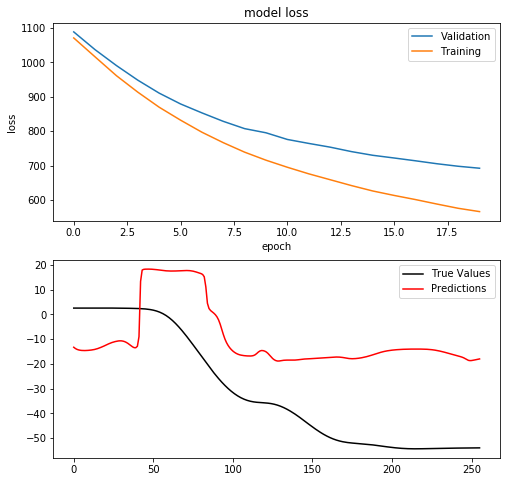

In [123]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Training')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
pred_y = model.predict(x=_X[valid_start:valid_start + BATCH_SIZE])
plt.plot(_Y[valid_start:valid_start + BATCH_SIZE, 0], 'k', label='True Values')
plt.plot(pred_y[:, 0], 'r', label='Predictions')
plt.legend()
plt.show()